## Resumo:

O objetivo do projeto é fazer uma analise exploratoria dos dados de covid extraidos do Brasil IO. O foco principal é analizar as taxas de casos e óbitos, primeiramente de um aspecto nacional e posteriormente no estado do Rio de Janeiro tentando entender porque os piores indicadores são os piores.  

  
  Para melhor visualização, recomento configurar o colab em dark mode: Ferramentas -> Configurações -> Tema: Dark

## Análise dos dados:


Primeiramente vamos entender o nosso dataset, como os dados estão gravados, que tipo de informação podemos tirar dele e quais suas falhas.

### Importando as bibliotecas

In [138]:
# Bibliotecas que nao estao no padrão do colab
!pip install jupyterthemes
!pip install geopandas

In [139]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
import geopandas as gpd

Configuração abaixo para tornar  os  graficos mais legiveis utilizando o tema  escuro:

In [140]:
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [141]:
### Dados

### Importanto os dados  
Os dados foram extraidos  da [Brasil IO](https://brasil.io/dataset/covid19/caso/), no dia 12-11-2020

In [142]:
dados_covid = pd.read_csv('https://www.dropbox.com/s/6vhga15llnr1wmo/caso_full.csv?dl=1')

Carregando os dados georeferenciados para traçar os limites das unidades federativas.

A fonte de dados é o [IBGE](https://www.ibge.gov.br/geociencias/downloads-geociencias.html)

In [143]:
geo_src = 'https://www.dropbox.com/s/6so56ucaehcekac/bcim_2016_21_11_2018.gpkg?dl=1'
UF_LIM = gpd.read_file(geo_src,layer='lim_unidade_federacao_a')
UF_LIM.drop(UF_LIM.columns[0:3],axis=1,inplace=True)
UF_LIM.drop(UF_LIM.columns[1:8],axis=1,inplace=True)
UF_LIM.rename(columns={'sigla':'ESTADO'},inplace=True)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


### Exploração incial dos dados  
O objetivo de fazer uma exploração inicial na base de dados é identificar o comportamento do datast, falhas, necessidades  de conversão, tamanho das colunas e  outras informações necessárias ao desenvolvimento do projeto

In [144]:
#Amostra aleatoria do nosso data set
dados_covid.sample(10)

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
161490,Paracambi,3303609.0,2020-06-04,23,52683.0,52257.0,False,False,219,415.69387,2020-06-04,0.0594,13,56,city,RJ,1,0
843663,Consolação,3118502.0,2020-10-08,41,1784.0,1783.0,False,False,2,112.10762,2020-10-08,0.0000,0,104,city,MG,0,0
173123,Paranaiguara,5216304.0,2020-06-07,24,10140.0,10057.0,False,False,4,39.44773,2020-06-07,0.0000,0,69,city,GO,0,0
864596,Barra de Santo Antônio,2700508.0,2020-10-12,42,16068.0,15932.0,False,False,133,827.73214,2020-10-12,0.0827,11,173,city,AL,0,0
673867,Maravilha,2704609.0,2020-09-08,37,9004.0,9163.0,False,False,73,810.75078,2020-09-08,0.0548,4,121,city,AL,0,0
401835,Guidoval,3128808.0,2020-07-21,30,7051.0,7078.0,False,False,1,14.18239,2020-07-21,0.0000,0,25,city,MG,0,0
956094,Inhaúma,3131000.0,2020-10-28,44,6312.0,6271.0,False,False,88,1394.16984,2020-10-28,0.0114,1,141,city,MG,4,0
1028389,Jataí,5211909.0,2020-11-10,46,102065.0,100882.0,True,False,4123,4039.58262,2020-11-10,0.0211,87,238,city,GO,11,0
165439,Recife,2611606.0,2020-06-05,23,1653461.0,1645727.0,False,False,16520,999.11640,2020-06-05,0.0731,1207,86,city,PE,270,30
876966,Bom Jesus das Selvas,2102036.0,2020-10-14,42,34567.0,34028.0,False,False,1723,4984.52281,2020-10-14,0.0070,12,162,city,MA,6,0


In [145]:
#formato do dataset, linhas x colunas
dados_covid.shape

(1038605, 18)

In [146]:
#Função para estatisticas basicas do nosso data set
dados_covid.describe()

,city_ibge_code,epidemiological_week,estimated_population,estimated_population_2019,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
count,1.034478e+06,1.038605e+06,1.034478e+06,1.034478e+06,1.038605e+06,1.020387e+06,1.038605e+06,1.038605e+06,1.038605e+06,1.038605e+06,1.038605e+06
mean,3.202752e+06,3.250429e+01,9.616536e+04,9.542685e+04,1.070170e+03,1.092717e+03,3.500892e-02,3.490985e+01,9.547952e+01,1.085391e+01,3.110461e-01
std,1.013799e+06,8.190521e+00,1.012643e+06,1.005322e+06,1.332354e+04,1.384576e+03,9.026940e-02,5.042752e+02,5.727905e+01,1.448364e+02,4.656631e+00
min,1.100000e+01,9.000000e+00,7.760000e+02,7.810000e+02,0.000000e+00,2.160000e-03,0.000000e+00,0.000000e+00,1.000000e+00,-6.791000e+03,-1.870000e+02
25%,2.505006e+06,2.600000e+01,6.064000e+03,6.046000e+03,1.300000e+01,1.369706e+02,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00
50%,3.141405e+06,3.300000e+01,1.343500e+04,1.335300e+04,6.300000e+01,6.248008e+02,1.530000e-02,1.000000e+00,9.300000e+01,0.000000e+00,0.000000e+00
75%,4.113809e+06,3.900000e+01,2.986000e+04,2.968900e+04,2.690000e+02,1.538894e+03,3.480000e-02,6.000000e+00,1.400000e+02,2.000000e+00,0.000000e+00
max,5.300108e+06,4.600000e+01,4.628933e+07,4.591905e+07,1.150872e+06,2.237154e+04,1.000000e+00,3.990700e+04,2.610000e+02,3.091300e+04,4.550000e+02


In [147]:
#Util para saber os tipos dos dados em cada coluna
dados_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038605 entries, 0 to 1038604
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype  
---  ------                                         --------------    -----  
 0   city                                           1032013 non-null  object 
 1   city_ibge_code                                 1034478 non-null  float64
 2   date                                           1038605 non-null  object 
 3   epidemiological_week                           1038605 non-null  int64  
 4   estimated_population                           1034478 non-null  float64
 5   estimated_population_2019                      1034478 non-null  float64
 6   is_last                                        1038605 non-null  bool   
 7   is_repeated                                    1038605 non-null  bool   
 8   last_available_confirmed                       1038605 non-null  int64  
 9   last_available_confirmed

É importante saber qual a porcentagem de dados validos(não nulos) da nossa base pois assim conseguimos garantir maior consistencia nos resultados. Caso tenha alguma coluna com um percentual baixo de dados validos, não irei considera-lo na analise.

In [148]:
round((dados_covid.notna().sum()/(dados_covid.notna().sum() + dados_covid.isna().sum()))*100,2)

city                                              99.37
city_ibge_code                                    99.60
date                                             100.00
epidemiological_week                             100.00
estimated_population                              99.60
estimated_population_2019                         99.60
is_last                                          100.00
is_repeated                                      100.00
last_available_confirmed                         100.00
last_available_confirmed_per_100k_inhabitants     98.25
last_available_date                              100.00
last_available_death_rate                        100.00
last_available_deaths                            100.00
order_for_place                                  100.00
place_type                                       100.00
state                                            100.00
new_confirmed                                    100.00
new_deaths                                      

### Limpeza do dataset

O próximo passo após exploração inicial é limpar e adequar o dataset de acordo com o nosso objetivo

In [149]:
#Converter os colunas com data para o tipo datetime
dados_covid['date'] = pd.to_datetime(dados_covid['date'], yearfirst=True).dt.date
dados_covid['last_available_date'] = pd.to_datetime(dados_covid['last_available_date'], yearfirst=True).dt.date

A [documentação](https://github.com/turicas/covid19-br/blob/master/api.md#casos) da nossa fonte de dados informa  que os valores da coluna _estimated_population_2019_ está desatualizada e orienta utilizar a coluna _estimated_population_ portanto podemos excluir ela do nosso dataset

In [150]:
dados_covid.drop('estimated_population_2019', axis=1, inplace=True)

Para nossa analise será necessário tambem sabermos a cidade do ocorrido, e temos algumas falhas nessas linhas(0,63%) então podemos elimina-las sem grande prejuizo.

In [151]:
dados_covid_uf = dados_covid.query("place_type == 'state'")
dados_covid = dados_covid.query("city != 'Importados/Indefinidos'")
dados_covid = dados_covid[dados_covid['city'].isna() == False]

In [152]:
round((dados_covid.notna().sum()/(dados_covid.notna().sum() + dados_covid.isna().sum()))*100,2)

city                                             100.00
city_ibge_code                                   100.00
date                                             100.00
epidemiological_week                             100.00
estimated_population                             100.00
is_last                                          100.00
is_repeated                                      100.00
last_available_confirmed                         100.00
last_available_confirmed_per_100k_inhabitants     98.63
last_available_date                              100.00
last_available_death_rate                        100.00
last_available_deaths                            100.00
order_for_place                                  100.00
place_type                                       100.00
state                                            100.00
new_confirmed                                    100.00
new_deaths                                       100.00
dtype: float64

Ainda temos a coluna _last_available_confirmed_per_100k_inhabitants_ com algumas  falhas, como podemos facilmente calcular esse  valor com os dados que nos já temos, iremos excluir esta coluna e adicionar uma nova com o nosso calculo.

In [153]:
dados_covid.drop('last_available_confirmed_per_100k_inhabitants', axis=1, inplace=True)
dados_covid['last_available_confirmed_per_100k_inhabitants'] = round(dados_covid['last_available_confirmed'] * (dados_covid['estimated_population']/100000),2)

In [154]:
print(round((dados_covid.notna().sum()/(dados_covid.notna().sum() + dados_covid.isna().sum()))*100,2))

city                                             100.0
city_ibge_code                                   100.0
date                                             100.0
epidemiological_week                             100.0
estimated_population                             100.0
is_last                                          100.0
is_repeated                                      100.0
last_available_confirmed                         100.0
last_available_date                              100.0
last_available_death_rate                        100.0
last_available_deaths                            100.0
order_for_place                                  100.0
place_type                                       100.0
state                                            100.0
new_confirmed                                    100.0
new_deaths                                       100.0
last_available_confirmed_per_100k_inhabitants    100.0
dtype: float64


In [155]:
#Limpeza do dataframe dos estados
dados_covid_uf.drop('city', axis=1, inplace=True)
dados_covid_uf.drop('last_available_confirmed_per_100k_inhabitants', axis=1, inplace=True)
dados_covid_uf['last_available_confirmed_per_100k_inhabitants'] = round(dados_covid_uf['last_available_confirmed'] * (dados_covid_uf['estimated_population']/100000),2)
print(round((dados_covid_uf.notna().sum()/(dados_covid_uf.notna().sum() + dados_covid_uf.isna().sum()))*100,2))

city_ibge_code                                   100.0
date                                             100.0
epidemiological_week                             100.0
estimated_population                             100.0
is_last                                          100.0
is_repeated                                      100.0
last_available_confirmed                         100.0
last_available_date                              100.0
last_available_death_rate                        100.0
last_available_deaths                            100.0
order_for_place                                  100.0
place_type                                       100.0
state                                            100.0
new_confirmed                                    100.0
new_deaths                                       100.0
last_available_confirmed_per_100k_inhabitants    100.0
dtype: float64


Agora a base está completa e podemos começar a plotar alguns gráficos exploratórios

### Primeiro Grafico Exploratorio

Foi amplamente divulgado o que o numero de mortes tem diminuido ao longo da  epidemia, então, podemos plotar um grafico com os valores de novas mortes por semana epidemiológica, caso seja verdade iremos observar um aumento nas semanas do meio e  uma redução nas  finais.

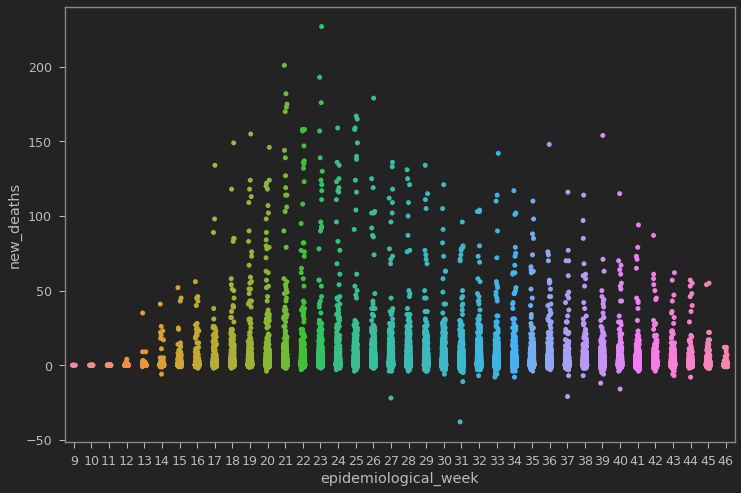

In [156]:
plt.figure( figsize=(12,8))
sns.stripplot(x='epidemiological_week',y='new_deaths',
               data=dados_covid[['epidemiological_week','new_deaths']])
plt.show()

Como os valores são por novas mortes, por dia e  por municipio, os valores são bem dispersos porem a  regra geral se mantem, é obseravel o comportamento de  redução à partir da semana  33. Porem algo chamou muita antenção, o numero de novas mortes negativas, como até hoje não há comprovação cientifica  de ressureição e tambem não foi noticiado nenhum inicio de apocalipse zumbi(não foi  dessa vez, #chateado), temos que descobrir o motivo desses numeros negativos, será uma falha no cadastro? Ou talvez possa ser uma correção nos numeros passados em dias anteriores?  
Mais uma vez, recorrendo a [documentação](https://github.com/turicas/covid19-br/blob/master/api.md#casos), podemos ver que os numeros negativos são de mortes  que foram remanejadas para outro municipio, estão registradas como negativo para que no somatorio total não se tenha um valor acima do real. Com base nessa informação podemos descartar esses dados da nossa base.

In [157]:
dados_covid = dados_covid.query("new_deaths >= 0")

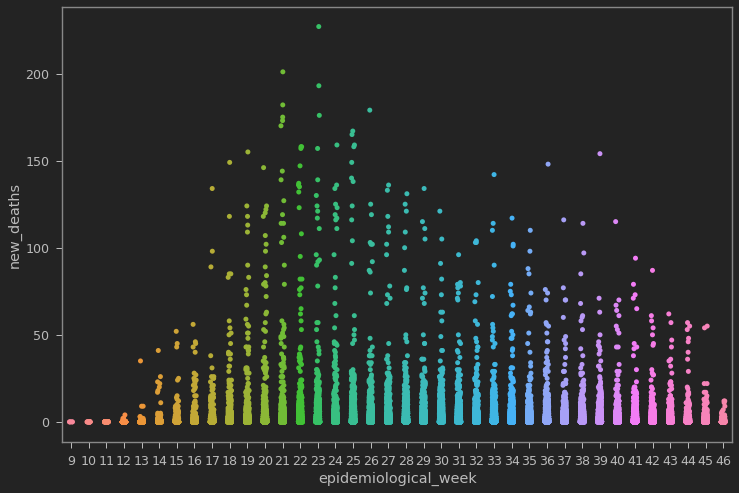

In [158]:
plt.figure( figsize=(12,8))
sns.stripplot(x='epidemiological_week',y='new_deaths',
               data=dados_covid[['epidemiological_week','new_deaths']])
plt.show()

## Analise Federal

O numero das semanas são correspondentes as semanas epidemiológicas de 2020, para saber mais acesse o [SINAN](http://www.portalsinan.saude.gov.br/calendario-epidemiologico)

### Evolução dos casos vs Evolução das mortes 

In [159]:
dados_covid_sem = pd.DataFrame()
dados_covid_sem['epidemiological_week'] =  dados_covid.epidemiological_week.unique()[:-3]

new_deaths=[]
new_confirmed=[]
for  i in dados_covid.epidemiological_week.unique()[:-3]:
    new_deaths.append(dados_covid['new_deaths'][dados_covid['epidemiological_week']==i].sum())
    new_confirmed.append(dados_covid['new_confirmed'][dados_covid['epidemiological_week']==i].sum())    
dados_covid_sem['new_deaths'] = new_deaths
dados_covid_sem['new_confirmed']=new_confirmed

Devido a demora nos resultados dos testes e sua divulgação no Brasil, fora desconsiderados as ultimas semanas, pois os valores de casos e obtitos tendiam a zero

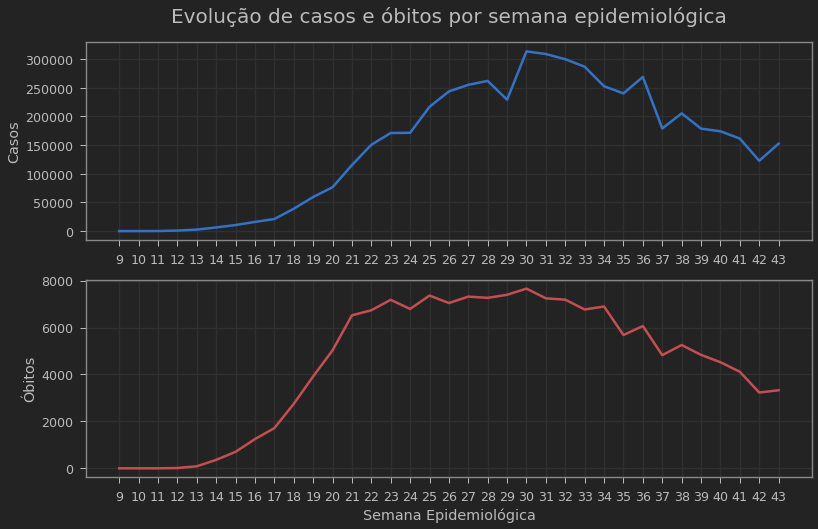

In [160]:
plt.figure(figsize=(13,8))

plt.subplot(2,1,2)
sns.lineplot(x='epidemiological_week',y='new_deaths',data=dados_covid_sem,color='r',linewidth=2.5)
plt.xticks(ticks=dados_covid_sem.epidemiological_week)
plt.ylabel('Óbitos')
plt.grid()
plt.xlabel('Semana Epidemiológica')
plt.subplot(2,1,1)
plt.title('Evolução de casos e óbitos por semana epidemiológica',pad=20, fontsize=20)
sns.lineplot(x='epidemiological_week',y='new_confirmed',data=dados_covid_sem,linewidth=2.5)
plt.xticks(ticks=dados_covid_sem.epidemiological_week)
plt.xlabel(None)
plt.ylabel('Casos')
plt.grid()
plt.show()

Em geral, os abitos acompanham os casos, porem há um comportamento anômalo nos casos da semana epidemiológica 29 que não foi refletido no obitos, como o tempo entre a infeção e a morte varia entre [2 a 8 semanas](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf), era para ter tido uma queda mais expressiva nas semanas 32 a 36, seguido de um aumento posterior em complemento. Acredito que isso seja um reflexo da dificuldade do Brasil na testagem em massa.

In [161]:
dados_covid_sem['death_rate']=round(dados_covid_sem['new_deaths']/dados_covid_sem['new_confirmed']*100,2)

global_cfr = round(1335308/55516793*100,2)

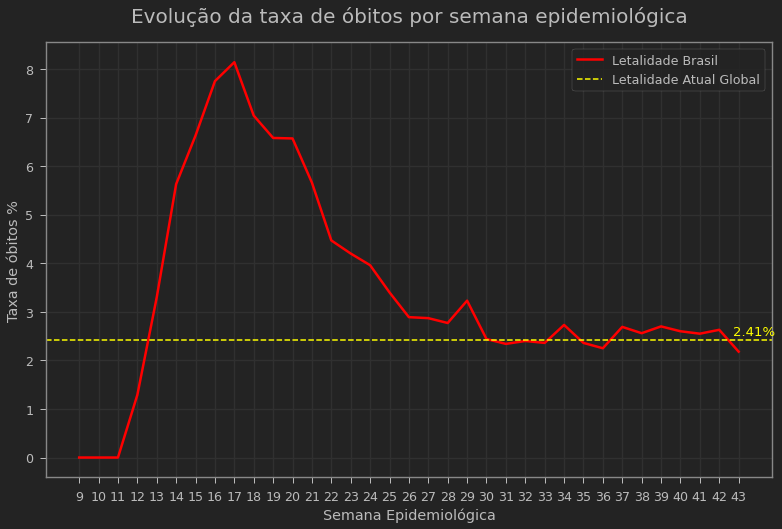

In [162]:
plt.figure(figsize=(13,8))
plt.title('Evolução da taxa de óbitos por semana epidemiológica',pad=20, fontsize=20)
sns.lineplot(x='epidemiological_week',y='death_rate',data=dados_covid_sem,linewidth=2.5,
            label='Letalidade Brasil',color='red')
plt.xticks(ticks=dados_covid_sem.epidemiological_week)
plt.ylabel('Taxa de óbitos %')
plt.xlabel('Semana Epidemiológica')
plt.axhline(global_cfr,color='yellow',ls='--',label='Letalidade Atual Global')
plt.annotate(str(global_cfr)+'%',c='yellow',xy=(42.7,global_cfr+0.1))
plt.legend()
plt.grid()
plt.show()

Letalidade global foi calculada no dia 17-11-2020 usando os dados do [worldometers](https://www.worldometers.info/coronavirus/)  
A alta letalidade brasileira no inicio da pandemia muito se deveu a [falta de testes e subnotificações](https://www.terra.com.br/noticias/coronavirus/por-que-o-brasil-testa-tao-pouco-para-covid-19,d1413429c5c200681d81d2c743ef89a3g18t7pxj.html) com maior testagem a taxa foi reduzindo como era de se esperar.  
A propria [who](https://www.who.int/news-room/commentaries/detail/estimating-mortality-from-covid-19) indica que a taxa é muito dificil de calcular em meio a uma pandemia devido a diversos fatores dos paises, como perfil populacional, capacidade de teste e metodos de medição, porem estima-se que o valor correto seria algo entre  0.5 e 1%.

### Comparação entre as unidades federativas

In [163]:
covid_uf = pd.DataFrame()
covid_uf['UF'] = dados_covid_uf.sort_values(by=['state']).state.unique()

In [164]:
total_deaths = []
total_cases= []
estimated_population = []
for i in covid_uf['UF']:
    total_deaths.append(dados_covid_uf['new_deaths'][dados_covid_uf['state']==i].sum())
    total_cases.append(dados_covid_uf['new_confirmed'][dados_covid_uf['state']==i].sum())
    estimated_population.append(dados_covid_uf['estimated_population'][dados_covid_uf['state']==i].iloc[-1])
                                
covid_uf['total deaths'] =total_deaths
covid_uf['total cases'] = total_cases
covid_uf['estimated_population'] = estimated_population                               
covid_uf['death_rate'] = round(covid_uf['total deaths']/covid_uf['total cases']*100,2)
covid_uf['deaths_per_100k_inhabitants']=round(covid_uf['total deaths']/(covid_uf['estimated_population']/100000),2)
covid_uf['cases_per_100k_inhabitants']=round(covid_uf['total cases']/(covid_uf['estimated_population']/100000),2)

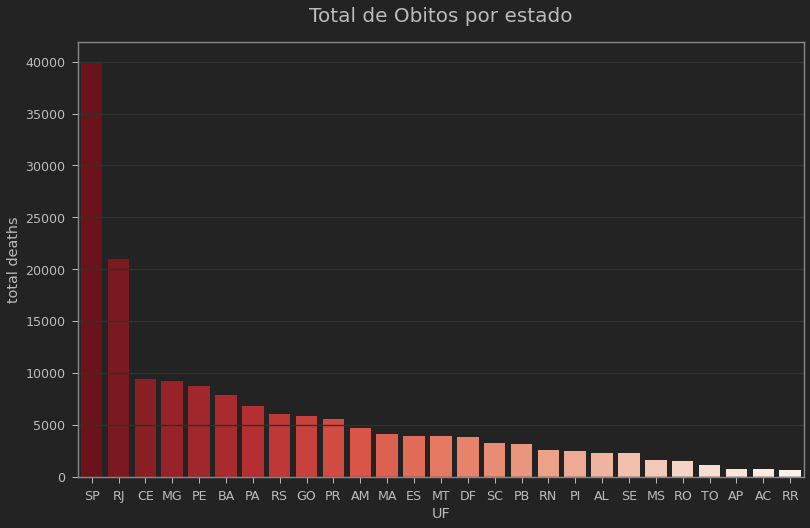

In [165]:
plt.figure(figsize=(13,8))
plt.title('Total de Obitos por estado',pad=20, fontsize=20)
sns.barplot(data=covid_uf.sort_values(by='total deaths',ascending=False),y='total deaths',x='UF',
            palette='Reds_r')
plt.grid(axis='y')
plt.show()

Claramente o estado de São Paulo tem o maior numero de obitos, porem o estado tambem tem o maior numero de habitantes do Pais então a maneira correta de avaliar o impacto no estado é analisar os obitos pela população conforme abaixo

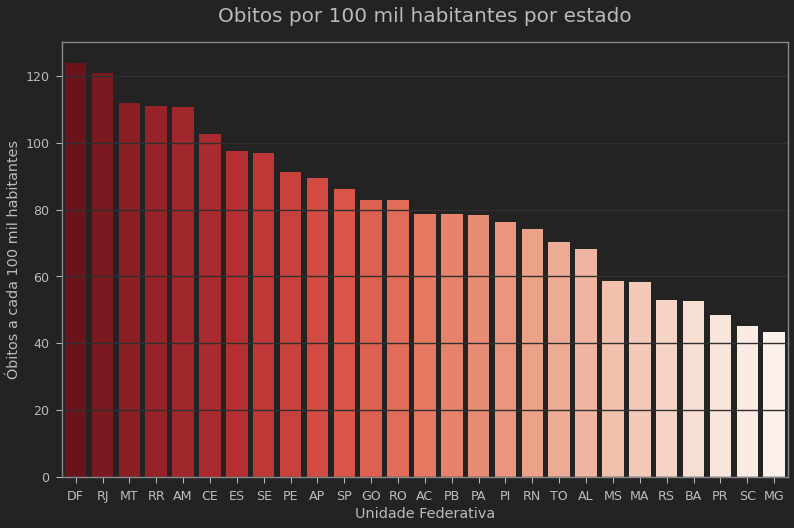

In [166]:
plt.figure(figsize=(13,8))
plt.title('Obitos por 100 mil habitantes por estado',pad=20, fontsize=20)
sns.barplot(data=covid_uf.sort_values(by='deaths_per_100k_inhabitants',ascending=False),y='deaths_per_100k_inhabitants',x='UF',
            palette='Reds_r')
plt.grid(axis='y')
plt.ylabel('Óbitos a cada 100 mil habitantes')
plt.xlabel('Unidade Federativa')

plt.show()

Proporcionalmente o distrito federal teve maior impacto em sua população e em seguida o Rio de Janeiro, cabe lembrar que estes possuem, em ordem, as maiores [densidades populacionais](ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Sinopse/Brasil/sinopse_brasil_tab_1_4.zip) do Brasil e isso pode ser de grande influencia pois aumenta a transmissibilidade do virus. Para confirmar podemos verificar os casos confirmados a cada 100 mil habitantes.

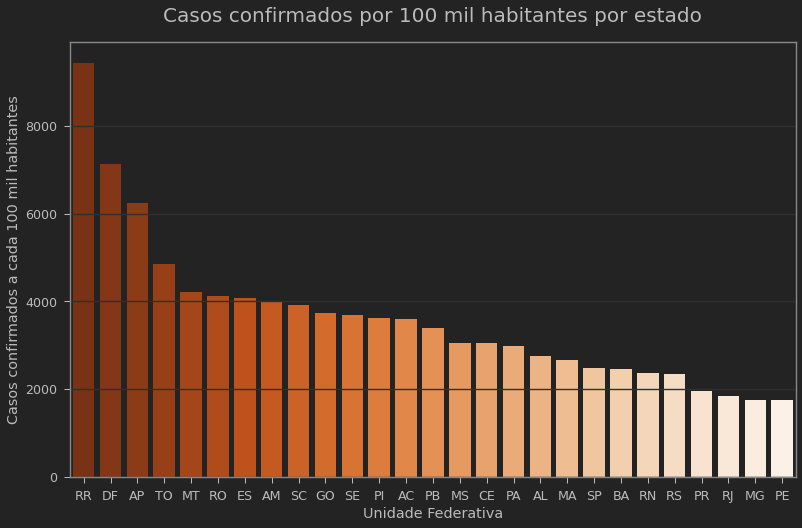

In [167]:
plt.figure(figsize=(13,8))
plt.title('Casos confirmados por 100 mil habitantes por estado',pad=20, fontsize=20)
sns.barplot(data=covid_uf.sort_values(by='cases_per_100k_inhabitants',ascending=False),y='cases_per_100k_inhabitants',x='UF',
            palette='Oranges_r')
plt.grid(axis='y')
plt.ylabel('Casos confirmados a cada 100 mil habitantes')
plt.xlabel('Unidade Federativa')

plt.show()

Para o distrito federal a hipotese sobre a densidade pode até ser válida porem não se aplica ao Rio de Janeiro, outra coisa pode ter causado elevada letalidade nesse estado, possivelmente falta de recurso médico adequado, cabe lembrar aqui que o [RJ é palco de um grande esquema de desvio de recursos](https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/09/29/esquemas-de-corrupcao-desviaram-quase-r-18-bilhao-da-saude-do-rj-desde-2007-valor-supera-gastos-com-a-pandemia.ghtml), ainda em investigação, para o combate a COVID-19. Isso pode explicar o motivo do RJ ter os maiores indices de obitos ao mesmo tempo que figura entre os menores indices de casos, o baixo indice de testes tambem podem corrobar com esse dado.


### Aspecto geral da taxa de mortes pelos estados Brasileiros

In [168]:
#Adicionando dados de geometria ao dataframe dos estados
covid_uf['geometry'] = UF_LIM.sort_values(by='ESTADO')['geometry']
covid_uf=gpd.GeoDataFrame(covid_uf)

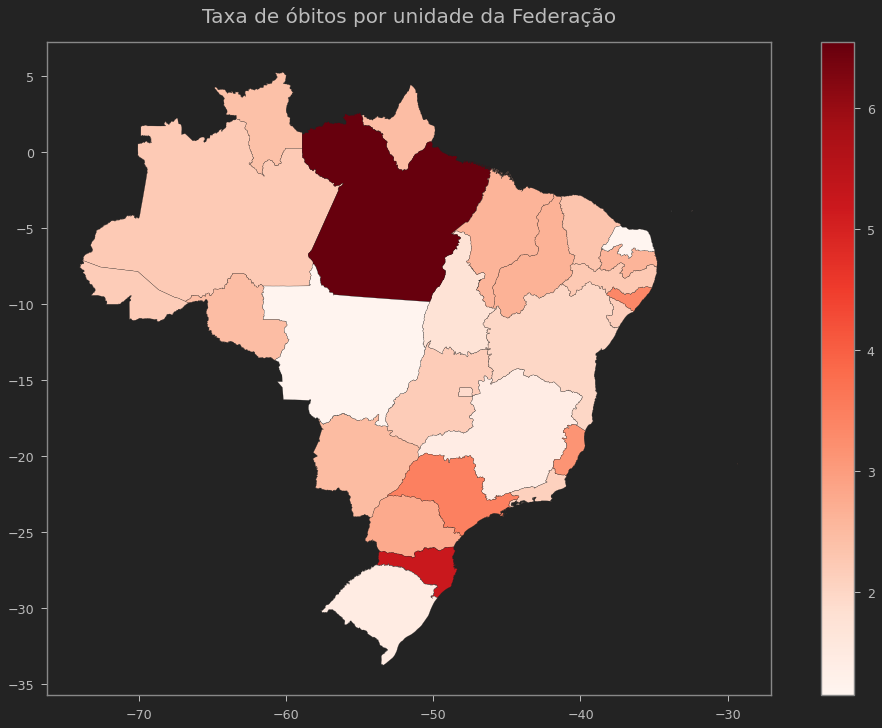

In [169]:
covid_uf.plot(column='death_rate',cmap='Reds', figsize=(18,12),legend=True,edgecolor='k')
plt.title('Taxa de óbitos por unidade da Federação',pad=20, fontsize=20)
plt.show()

Neste mapa podemos ver claramente em como o Pará se destaca na taxa de mortalidade, infelizemnte o estado passa por [dificuldades no sistema de saude](https://www.terra.com.br/vida-e-estilo/saude/no-para-mortes-e-atendimento-precario-acentuam-a-covid-19,4fffb6ade65dbcbc68a043c4a85cb6c6u4oghwjd.html) somando com a [dificuldade histórica de acesso ao sistema de saude](http://www.jornalbeiradorio.ufpa.br/novo/index.php/2015/157-2015-03-26-14-05-01/1681-2015-03-26-14-27-46) e uma capital com [elevado indice de contaminação](https://noticias.uol.com.br/saude/ultimas-noticias/redacao/2020/07/02/belem-40-de-contaminados-em-testagem-aposta-em-imunizacao.htm), culminou neste triste resultado.

## Analise do Estado do RJ

Neste Tópico iremos entrar em mais detalhes sobre os casos no Rio de Janeiro, meu estado, e seus municipios. A começar pela distribuição dos casos nos municipios do estado.

### Construção dos Dataframes necessários para os graficos do RJ

In [170]:
# Df somente com os dados do RJ
dados_covid_rj = dados_covid.query('state == "RJ"')

In [171]:
dados_covid_rj_sem = pd.DataFrame()
dados_covid_rj_sem['epidemiological_week'] =  dados_covid_rj.epidemiological_week.unique()[:-3]

new_deaths=[]
new_confirmed=[]
for  i in dados_covid_rj.epidemiological_week.unique()[:-3]:
    new_deaths.append(dados_covid_rj['new_deaths'][dados_covid_rj['epidemiological_week']==i].sum())
    new_confirmed.append(dados_covid_rj['new_confirmed'][dados_covid_rj['epidemiological_week']==i].sum())    
dados_covid_rj_sem['new_deaths'] = new_deaths
dados_covid_rj_sem['new_confirmed']=new_confirmed

In [178]:
dados_covid_rj_mu = pd.DataFrame()
dados_covid_rj_mu['city'] = dados_covid_rj.sort_values(by='city').city.unique()
dados_covid_rj_mu['city'] = dados_covid_rj_mu.sort_values('city')

In [179]:
geometria_municipios = gpd.read_file('https://www.dropbox.com/s/dxxttzav5rhj4n0/lim_municipios_rj.gpkg?dl=1')

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [180]:
dados_covid_rj_mu['geometry'] = geometria_municipios.sort_values('NM_MUNICIP')['geometry']
dados_covid_rj_mu = gpd.GeoDataFrame(dados_covid_rj_mu)

total_deaths = []
total_cases= []
estimated_population = []
for i in dados_covid_rj_mu['city']:
    total_deaths.append(dados_covid_rj['new_deaths'][dados_covid_rj['city']==i].sum())
    total_cases.append(dados_covid_rj['new_confirmed'][dados_covid_rj['city']==i].sum())
    estimated_population.append(dados_covid_rj['estimated_population'][dados_covid_rj['city']==i].iloc[-1])
                                
dados_covid_rj_mu['total deaths'] =total_deaths
dados_covid_rj_mu['total cases'] = total_cases
dados_covid_rj_mu['estimated_population'] = estimated_population                               
dados_covid_rj_mu['death_rate'] = round(dados_covid_rj_mu['total deaths']/dados_covid_rj_mu['total cases']*100,2)
dados_covid_rj_mu['deaths_per_10k_inhabitants']=round(dados_covid_rj_mu['total deaths']/(dados_covid_rj_mu['estimated_population']/10000),2)
dados_covid_rj_mu['cases_per_10k_inhabitants']=round(dados_covid_rj_mu['total cases']/(dados_covid_rj_mu['estimated_population']/10000),2)

### Evolução de casos e óbitos

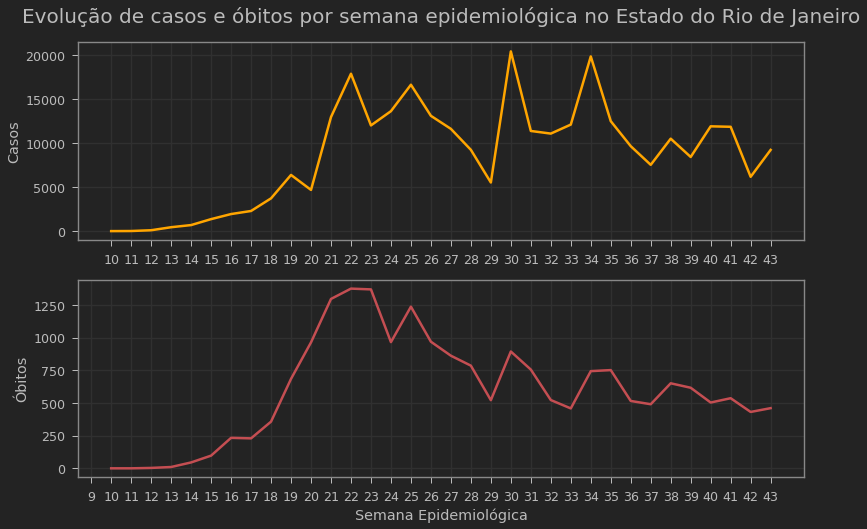

In [181]:
plt.figure(figsize=(13,8))

plt.subplot(2,1,2)
sns.lineplot(x='epidemiological_week',y='new_deaths',data=dados_covid_rj_sem,color='r',linewidth=2.5)
plt.xticks(ticks=dados_covid_sem.epidemiological_week)
plt.ylabel('Óbitos')
plt.grid()
plt.xlabel('Semana Epidemiológica')
plt.subplot(2,1,1)
plt.title('Evolução de casos e óbitos por semana epidemiológica no Estado do Rio de Janeiro',pad=20, fontsize=20)
sns.lineplot(x='epidemiological_week',y='new_confirmed',data=dados_covid_rj_sem,linewidth=2.5,color='orange')
plt.xticks(ticks=dados_covid_rj_sem.epidemiological_week)
plt.xlabel(None)
plt.ylabel('Casos')
plt.grid()
plt.show()

Em linhas gerais os gráficos se assemelham muito, o que é estranho uma vez que os obitos acabam acontecendo posterior ao caso. Isso pode estar acontecendo devido à uma enorme falha de testagem onde os casos só estao sendo confirmados pós óbito fazendo entao as datas convergirem. Os picos nas semanas 30 e 34 parece ser causado pelos multirões de testagem em massa que foram feitos tardiamente no estado.

### Obitos e Casos totais por municipio

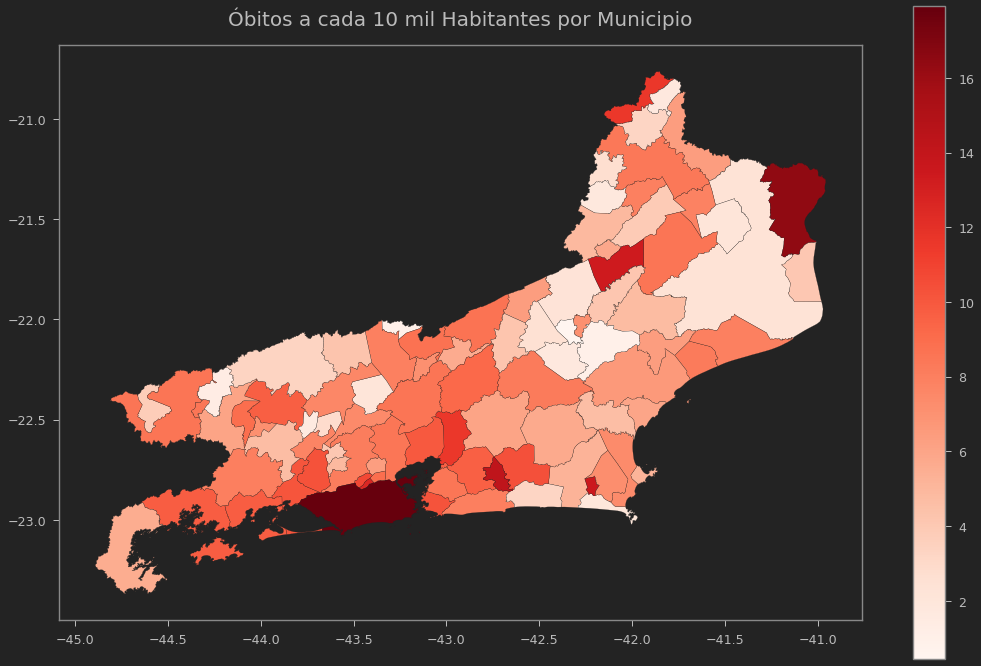

In [182]:
dados_covid_rj_mu.plot(column='deaths_per_10k_inhabitants',cmap='Reds', figsize=(18,12),legend=True,edgecolor='k')
plt.title('Óbitos a cada 10 mil Habitantes por Municipio',pad=20, fontsize=20)
plt.show()

Temos aqui a capital se destacando com o numero de óbitos a cada 10 mil habitantes seguido do municipio de São Franscisco do Itabapoana na Região Norte Fluminense. o municipio de São Franscisco do Itabapoana é o segundo municipio menos desenvolvido do estado e possui parcos recursos o que pode explicar a sua alta taxa de obitos em relação a sua população, o municipio tambem não possui nenhum leito de UTI tendo que recorrer a munipios vizinhos.

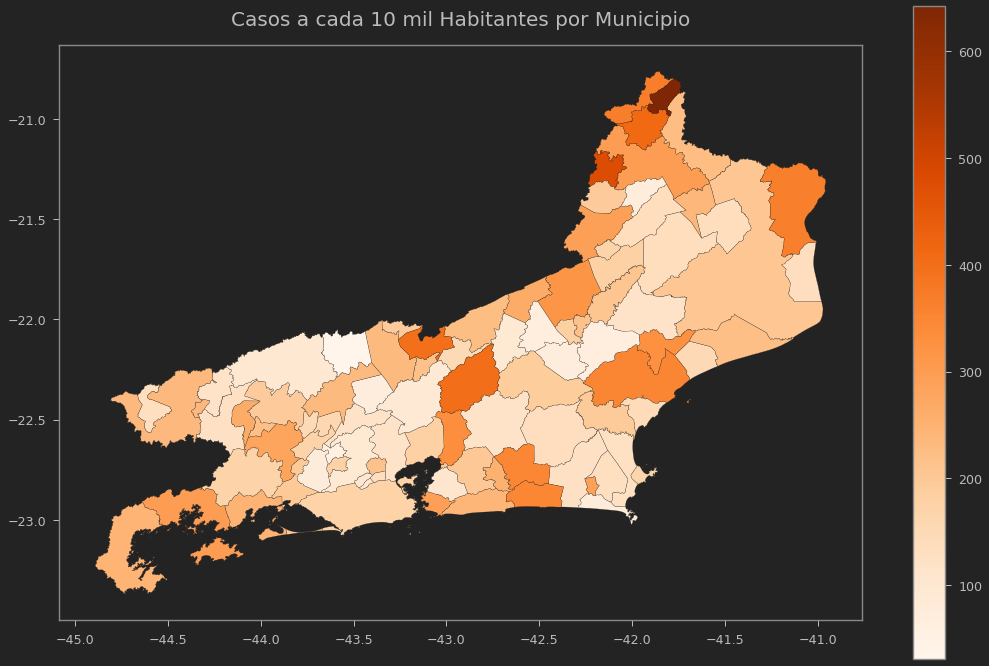

In [183]:
dados_covid_rj_mu.plot(column='cases_per_10k_inhabitants',cmap='Oranges', figsize=(18,12),legend=True,edgecolor='k')
plt.title('Casos a cada 10 mil Habitantes por Municipio',pad=20, fontsize=20)
plt.show()

Já analisando o numero de casos por habitantes, temos o destaque do municipio de Varre-Sai, não se tem uma explição para isso até o momento, a cidade foi [noticia em setembro](http://www.macaenews.com.br/noticia/43668-varre-sai-supera-macae-em-casos-de-covid-19-na-ultima-semana-com-populacao-23-vezes-menor) por conta uma explosão de casos mesmo tendo testado apenas 15% da população, ou seja o numero real de casos pode ser até maior.

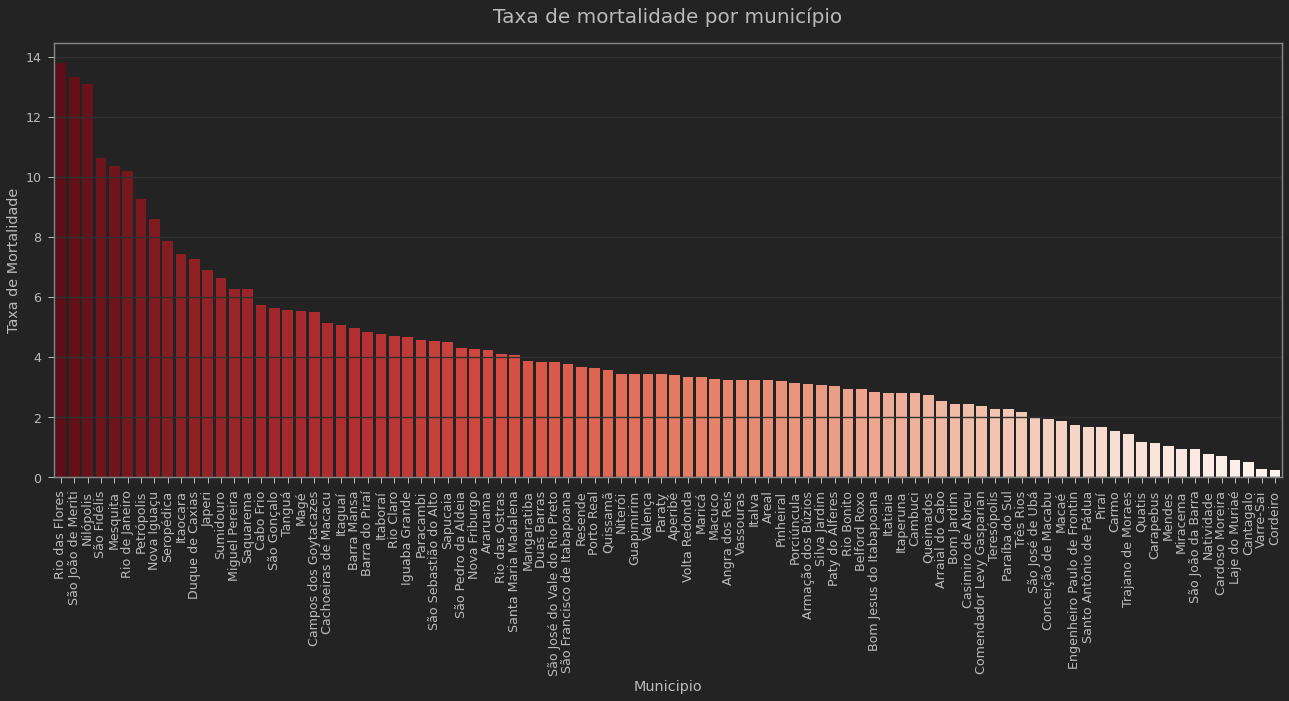

In [184]:
plt.figure(figsize=(22,8))
plt.title('Taxa de mortalidade por município',pad=20, fontsize=20)
sns.barplot(data=dados_covid_rj_mu.sort_values(by='death_rate',ascending=False),y='death_rate',x='city',
            palette='Reds_r')
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.ylabel('Taxa de Mortalidade')
plt.xlabel('Municipio')

plt.show()

Por fim temos a taxa de mortalidade por municipio, é notável a figuração das cidades da baixada fluminence nos maiores indices, cidades essas historicamente são negligenciados pelo serviço público.